In [2]:
# %%!pip install transformers
# %pip install pymorphy2
# %pip install scikit-learn==1.4.2

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
import pymorphy2
import string
import re
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
tqdm.pandas()
from wordcloud import WordCloud
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW, AutoModelForSequenceClassification

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dasha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
with open("C:\\Users\\Dasha\\Desktop\\ВКР\\post_with_emb.pickle", 'rb') as file_one:
    posts = pickle.load(file_one)

In [5]:
posts.head()

,id,owner_id,date,views,likes,reposts,text,text_norm,конверсия,len_text,label,emb
0,48679755,-40316705,1685276161,3518,20,1,Песков: Путину немедленно докладывают в случае...,песок путин немедленно докладывать случай круп...,0.006254,8,0.007655,"[0.29642948508262634, -0.1393176019191742, 0.0..."
1,48679701,-40316705,1685275740,5267,56,4,Пикник по-киевски: пожарил мясо — получил пове...,пикник киевск пожарить мясо получить повестка ...,0.012151,45,0.006681,"[0.11712794750928879, -0.09262416511774063, -0..."
2,48679624,-40316705,1685275323,7237,42,1,❗Масштабного скопления ВСУ на Северском направ...,масштабный скопление всу северский направление...,0.006080,102,0.006394,"[0.10306470841169357, -0.04626309499144554, -0..."
3,48679548,-40316705,1685274900,5218,10,0,Камельзон назвал главного фаворита «Ролан Гарр...,камельзон назвать главное фаворит ролан гаррос...,0.001916,7,0.007650,"[0.11831574887037277, -0.12643136084079742, 0...."
4,48679463,-40316705,1685274480,6030,44,10,Глава Минобороны Сербии предупредил о риске на...,глава минобороны сербия предупредить риска нач...,0.010614,10,0.004766,"[0.10738948732614517, -0.1751793920993805, -0...."


In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(np.array(posts['emb'].tolist()))

In [6]:
emb_smaller = pca.transform(np.array(posts['emb'].tolist()))

In [7]:
df_with_smaller_emb = pd.DataFrame(emb_smaller,columns = ['X', 'Y'])

In [8]:
df_with_smaller_emb.head()

,X,Y
0,0.924620,-0.563068
1,0.484519,-0.288117
2,0.175142,1.195746
3,0.854329,0.032426
4,-0.439384,0.302362


In [9]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
n_clusters_max = 9
inertia_list = []
stable_silhouette = []

for n_clusters in range(2, n_clusters_max + 1):
  kmeans_l = MiniBatchKMeans(n_clusters, random_state=21).fit(np.array(posts['emb'].tolist()))
  stable_silhouette.append(silhouette_score(np.array(posts['emb'].tolist()), kmeans_l.labels_))
  inertia_list.append(kmeans_l.inertia_)

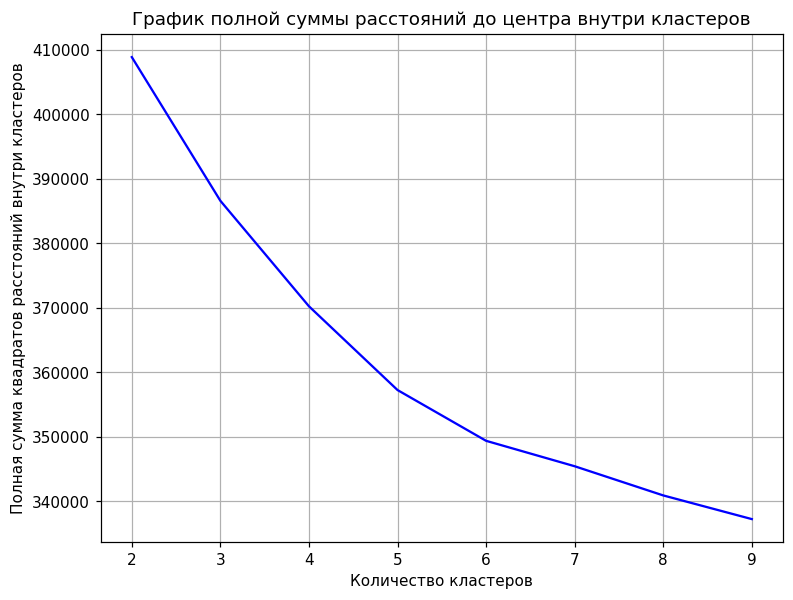

In [10]:
plt.figure(figsize = (8, 6), dpi = 110)
plt.plot(range(2, n_clusters_max + 1), inertia_list, c = 'b')
plt.grid()
plt.title("График полной суммы расстояний до центра внутри кластеров")
plt.xlabel("Количество кластеров")
plt.ylabel("Полная сумма квадратов расстояний внутри кластеров")
plt.show()

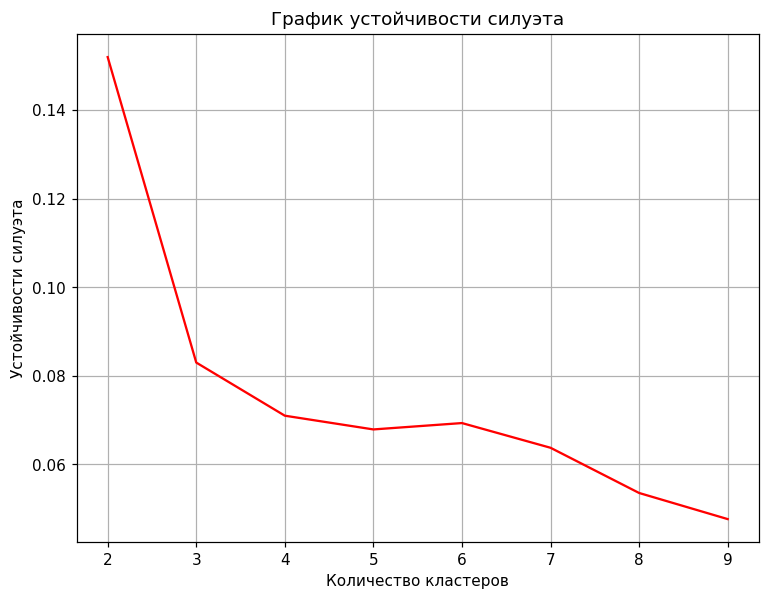

In [11]:
plt.figure(figsize = (8, 6), dpi = 110)
plt.plot(range(2, n_clusters_max + 1), stable_silhouette, c = 'r')
plt.grid()
plt.title("График устойчивости силуэта")
plt.xlabel("Количество кластеров")
plt.ylabel("Устойчивости силуэта")
plt.show()

In [12]:
kmeans_l = MiniBatchKMeans(6, random_state=21).fit(np.array(posts['emb'].tolist()))

In [13]:
df_with_smaller_emb['label'] = kmeans_l.labels_

In [14]:
df_with_smaller_emb.head()

,X,Y,label
0,0.924620,-0.563068,3
1,0.484519,-0.288117,3
2,0.175142,1.195746,5
3,0.854329,0.032426,5
4,-0.439384,0.302362,1


<AxesSubplot:xlabel='X', ylabel='Y'>

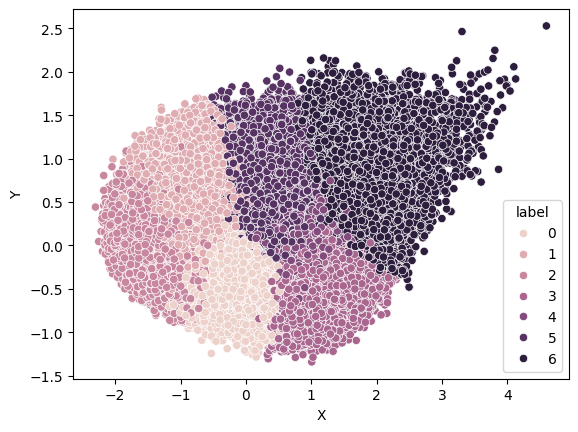

In [15]:
sns.scatterplot(data = df_with_smaller_emb, x = 'X', y = 'Y', hue = 'label')

In [17]:
df_with_smaller_emb['конверсия'] = posts['конверсия']

In [18]:
from scipy.stats import f_oneway
f_oneway(df_with_smaller_emb[df_with_smaller_emb['label'] == 0]['конверсия'], 
         df_with_smaller_emb[df_with_smaller_emb['label'] == 1]['конверсия'],
         df_with_smaller_emb[df_with_smaller_emb['label'] == 2]['конверсия'],
         df_with_smaller_emb[df_with_smaller_emb['label'] == 3]['конверсия'],
         df_with_smaller_emb[df_with_smaller_emb['label'] == 4]['конверсия'],
         df_with_smaller_emb[df_with_smaller_emb['label'] == 5]['конверсия'],
         df_with_smaller_emb[df_with_smaller_emb['label'] == 6]['конверсия'],)  

F_onewayResult(statistic=7976.4312373048415, pvalue=0.0)

In [19]:
def closest_vector(posts, target_vector):
    posts = posts[posts['конверсия'] > 0.003523]
    dataset = list(posts['emb'])
    cosine_distances = np.dot(dataset, target_vector) / (np.linalg.norm(dataset, axis=1) * np.linalg.norm(target_vector))
    posts['cos_distance'] = cosine_distances
    posts = posts[posts['cos_distance']<0.999999].reset_index(drop = True)
    closest_vector_index = np.argmax(posts['cos_distance'])
    return posts.text.iloc[closest_vector_index]

In [20]:
def remove_stopwords(txt):
    rus_stopwords = stopwords.words('russian')
    morph = pymorphy2.MorphAnalyzer(probability_estimator_cls=None)
    
    s = ''
    txt = txt.strip()
    txt = txt.translate(str.maketrans({key: " {0} ".format(key) for key in string.punctuation}))
    txt = re.sub(r'[^\w\s]|\n', ' ', txt)
    txt = txt.lower()
    txt = re.sub('[^а-яА-ЯёЁ*\W]',' ',txt)
    for word in txt.split():
        word = morph.parse(word)[0].normal_form
        if word not in rus_stopwords:
            if word not in ['также', 'весь', 'это', 'который', 'иза', 'еще', 'ещё', 'ее', 'её', 'свой']:
                s = s+ word + ' '
    s = s[:-1]
    return s


def count_emb(text):
    tokenizer = AutoTokenizer.from_pretrained('DARUSHKA2161/distilbert-base-multilingual-cased-vk-posts')
    model = AutoModel.from_pretrained('DARUSHKA2161/distilbert-base-multilingual-cased-vk-posts')
    encoding = tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            return_attention_mask = True,
            return_tensors ='pt')
    outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
    return outputs.last_hidden_state[0,0,:].tolist()

In [6]:
import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pymorphy2
import numpy as np
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dasha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
clean_text = remove_stopwords('Простой турецкий избиратель голосует с барашком на поводке. За кого — не знаем, но перформанс со смыслом')
clean_text

'простой турецкий избиратель голосовать барашком поводок знать перформанс смысл'

In [23]:
emb = count_emb(clean_text)
emb

c:\Users\Dasha\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[0.14359045028686523,
 -0.18214160203933716,
 0.1148834079504013,
 0.07190074026584625,
 0.16723482310771942,
 -0.1376437097787857,
 -0.08345597982406616,
 -0.12006959319114685,
 0.2648233473300934,
 0.24789303541183472,
 -0.25731369853019714,
 0.29010576009750366,
 -0.16376745700836182,
 -0.023392021656036377,
 0.10481587052345276,
 -0.16730013489723206,
 0.1476769894361496,
 -0.2702168822288513,
 -0.3160575330257416,
 0.023873981088399887,
 -0.08931189030408859,
 -0.22874778509140015,
 0.19655492901802063,
 0.18286192417144775,
 0.12636984884738922,
 0.15977051854133606,
 -0.06390053778886795,
 0.13566239178180695,
 0.1722123920917511,
 -0.28490716218948364,
 0.414273202419281,
 -0.23315134644508362,
 -0.2306358963251114,
 -0.038532763719558716,
 -0.038513269275426865,
 0.29981592297554016,
 0.3369353413581848,
 0.29687368869781494,
 0.14444206655025482,
 -0.18853269517421722,
 -0.22379523515701294,
 -0.005362396128475666,
 0.04227447509765625,
 0.01773998886346817,
 -0.3798425793647

In [24]:
closest_vector(posts, emb)

C:\Temp\ipykernel_3664\10304741.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts['cos_distance'] = cosine_distances


'Спикер Госдумы Вячеслав Володин не исключил, что может состояться еще одно внеочередное пленарное заседание Думы:\\nhttp://go.tass.ru/jnCrs'

In [7]:
posts.head()

,id,owner_id,date,views,likes,reposts,text,text_norm,конверсия,len_text,label,emb
0,48679755,-40316705,1685276161,3518,20,1,Песков: Путину немедленно докладывают в случае...,песок путин немедленно докладывать случай круп...,0.006254,8,0.007655,"[0.29642948508262634, -0.1393176019191742, 0.0..."
1,48679701,-40316705,1685275740,5267,56,4,Пикник по-киевски: пожарил мясо — получил пове...,пикник киевск пожарить мясо получить повестка ...,0.012151,45,0.006681,"[0.11712794750928879, -0.09262416511774063, -0..."
2,48679624,-40316705,1685275323,7237,42,1,❗Масштабного скопления ВСУ на Северском направ...,масштабный скопление всу северский направление...,0.006080,102,0.006394,"[0.10306470841169357, -0.04626309499144554, -0..."
3,48679548,-40316705,1685274900,5218,10,0,Камельзон назвал главного фаворита «Ролан Гарр...,камельзон назвать главное фаворит ролан гаррос...,0.001916,7,0.007650,"[0.11831574887037277, -0.12643136084079742, 0...."
4,48679463,-40316705,1685274480,6030,44,10,Глава Минобороны Сербии предупредил о риске на...,глава минобороны сербия предупредить риска нач...,0.010614,10,0.004766,"[0.10738948732614517, -0.1751793920993805, -0...."


In [8]:
import pickle
with open("UI_for_model\\analysis_base\\one_n_gram.pickle", 'rb') as file_one:
    one_n_gram = pickle.load(file_one)

with open("UI_for_model\\analysis_base\\two_n_gram.pickle", 'rb') as file_one:
    two_n_gram = pickle.load(file_one)

with open("UI_for_model\\analysis_base\\three_n_gram.pickle", 'rb') as file_one:
    three_n_gram = pickle.load(file_one)

In [9]:
get_features = pd.concat([one_n_gram.sort_values('freq_dif').head(100),
            one_n_gram.sort_values('freq_dif').tail(100),
            two_n_gram.sort_values('freq_dif').head(100),
            two_n_gram.sort_values('freq_dif').tail(100),
            three_n_gram.sort_values('freq_dif').head(100),
            three_n_gram.sort_values('freq_dif').tail(100)])

In [10]:
string_d = 'Простой турецкий избиратель голосует с барашком на поводке. За кого — не знаем, но перформанс со смыслом'
string_d

'Простой турецкий избиратель голосует с барашком на поводке. За кого — не знаем, но перформанс со смыслом'

In [11]:
from nltk import ngrams
from collections import Counter
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dasha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
def get_dataframe_freq(n, text):
  def count_ngrams(tokens, n):
      ngrams_list = ngrams(tokens, n)
      return Counter(ngrams_list)

  tokens = nltk.word_tokenize(text.lower())
  ngram_freq = count_ngrams(tokens, n)
  df = pd.DataFrame(data = list(ngram_freq.items()), columns = ['n_gram', 'freq'])
  df = df.sort_values('freq')
  return df

In [13]:
text_frame = pd.concat([get_dataframe_freq(1, clean_text), get_dataframe_freq(2, clean_text), get_dataframe_freq(3, clean_text)])
text_frame

NameError: name 'clean_text' is not defined

In [14]:
pd.merge(get_features, text_frame, on = 'n_gram')

NameError: name 'text_frame' is not defined

In [15]:
posts.head()

,id,owner_id,date,views,likes,reposts,text,text_norm,конверсия,len_text,label,emb
0,48679755,-40316705,1685276161,3518,20,1,Песков: Путину немедленно докладывают в случае...,песок путин немедленно докладывать случай круп...,0.006254,8,0.007655,"[0.29642948508262634, -0.1393176019191742, 0.0..."
1,48679701,-40316705,1685275740,5267,56,4,Пикник по-киевски: пожарил мясо — получил пове...,пикник киевск пожарить мясо получить повестка ...,0.012151,45,0.006681,"[0.11712794750928879, -0.09262416511774063, -0..."
2,48679624,-40316705,1685275323,7237,42,1,❗Масштабного скопления ВСУ на Северском направ...,масштабный скопление всу северский направление...,0.006080,102,0.006394,"[0.10306470841169357, -0.04626309499144554, -0..."
3,48679548,-40316705,1685274900,5218,10,0,Камельзон назвал главного фаворита «Ролан Гарр...,камельзон назвать главное фаворит ролан гаррос...,0.001916,7,0.007650,"[0.11831574887037277, -0.12643136084079742, 0...."
4,48679463,-40316705,1685274480,6030,44,10,Глава Минобороны Сербии предупредил о риске на...,глава минобороны сербия предупредить риска нач...,0.010614,10,0.004766,"[0.10738948732614517, -0.1751793920993805, -0...."


In [16]:
get_features.head(3)

,n_gram,freq_up,freq_down,freq_dif
36199,"(видео,)",0.005042,0.001083,-0.003959
36188,"(всу,)",0.002921,0.001243,-0.001677
36190,"(подробный,)",0.003154,0.001606,-0.001548


In [17]:
df_features = pd.DataFrame(columns = [str(i) for i in get_features['n_gram']])
df_features

,"('видео',)","('всу',)","('подробный',)","('тасс',)","('наш',)","('минобороны',)","('кадр',)","('путин',)","('рф',)","('житель',)",...,"('собрать', 'главное', 'новость')","('президент', 'россия', 'владимир')","('военный', 'операция', 'украина')","('санкция', 'против', 'россия')","('стать', 'известный', 'ъ')","('президент', 'сша', 'джо')","('сша', 'джо', 'байден')","('президент', 'украина', 'владимир')","('украина', 'владимир', 'зеленский')","('рбк', 'тренд', 'рбктренд')"


In [18]:
df_features['label'] = posts['label']
df_features['len_text'] = posts['len_text']
df_features['конверсия'] = posts['конверсия']
df_features['text_norm'] = posts['text_norm']

In [19]:
df_features.head(3)

,"('видео',)","('всу',)","('подробный',)","('тасс',)","('наш',)","('минобороны',)","('кадр',)","('путин',)","('рф',)","('житель',)",...,"('стать', 'известный', 'ъ')","('президент', 'сша', 'джо')","('сша', 'джо', 'байден')","('президент', 'украина', 'владимир')","('украина', 'владимир', 'зеленский')","('рбк', 'тренд', 'рбктренд')",label,len_text,конверсия,text_norm
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.007655,8,0.006254,песок путин немедленно докладывать случай круп...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.006681,45,0.012151,пикник киевск пожарить мясо получить повестка ...
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.006394,102,0.006080,масштабный скопление всу северский направление...


In [20]:
df_features.loc[1, "('видео',)"]

nan

In [21]:
for i in tqdm(range(len(df_features))):
    text = df_features['text_norm'][i]
    text_frame = pd.concat([get_dataframe_freq(1, text), get_dataframe_freq(2, text), get_dataframe_freq(3, text)])
    columns_put = [str(i) for i in pd.merge(get_features, text_frame, on = 'n_gram')['n_gram']]
    for col in columns_put:
        df_features.loc[i, col] = 1

  0%|          | 0/137722 [00:00<?, ?it/s]

In [22]:
df_features.isna().sum()

('видео',)                      126365
('всу',)                        131705
('подробный',)                  128232
('тасс',)                       131145
('наш',)                        130667
                                 ...  
('рбк', 'тренд', 'рбктренд')    137015
label                                0
len_text                             0
конверсия                            0
text_norm                            0
Length: 604, dtype: int64

In [23]:
df_features.shape

(137722, 604)

In [24]:
df_features = df_features.fillna(0)

In [25]:
df_features.head()

,"('видео',)","('всу',)","('подробный',)","('тасс',)","('наш',)","('минобороны',)","('кадр',)","('путин',)","('рф',)","('житель',)",...,"('стать', 'известный', 'ъ')","('президент', 'сша', 'джо')","('сша', 'джо', 'байден')","('президент', 'украина', 'владимир')","('украина', 'владимир', 'зеленский')","('рбк', 'тренд', 'рбктренд')",label,len_text,конверсия,text_norm
0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0.007655,8,0.006254,песок путин немедленно докладывать случай круп...
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.006681,45,0.012151,пикник киевск пожарить мясо получить повестка ...
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.006394,102,0.006080,масштабный скопление всу северский направление...
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.007650,7,0.001916,камельзон назвать главное фаворит ролан гаррос...
4,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0.004766,10,0.010614,глава минобороны сербия предупредить риска нач...


In [26]:
# %pip install catboost

In [27]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df_features.drop(['конверсия' , 'text_norm'], axis = 1), df_features['конверсия'], test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

In [48]:
df_features.to_csv('df_features.csv', index = False)

In [29]:
# %pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:
model = CatBoostRegressor(loss_function='RMSE', eval_metric='R2').fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.106538
0:	learn: 0.0603256	test: 0.0554844	best: 0.0554844 (0)	total: 138ms	remaining: 2m 17s
100:	learn: 0.3548705	test: 0.3092813	best: 0.3092813 (100)	total: 4.34s	remaining: 38.6s
200:	learn: 0.3772654	test: 0.3160067	best: 0.3160067 (200)	total: 8.46s	remaining: 33.6s
300:	learn: 0.3919447	test: 0.3193886	best: 0.3193886 (300)	total: 12.3s	remaining: 28.7s
400:	learn: 0.4040676	test: 0.3220644	best: 0.3220644 (400)	total: 17.6s	remaining: 26.3s
500:	learn: 0.4141533	test: 0.3229066	best: 0.3229135 (497)	total: 21.4s	remaining: 21.3s
600:	learn: 0.4239408	test: 0.3239865	best: 0.3240929 (580)	total: 25.2s	remaining: 16.7s
700:	learn: 0.4321930	test: 0.3244372	best: 0.3245233 (690)	total: 29.2s	remaining: 12.5s
800:	learn: 0.4395283	test: 0.3251999	best: 0.3252543 (788)	total: 35.3s	remaining: 8.77s
900:	learn: 0.4464015	test: 0.3252931	best: 0.3253804 (897)	total: 41.4s	remaining: 4.55s
999:	learn: 0.4525673	test: 0.3253933	best: 0.3256273 (978)	total: 47.6s	

In [50]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R2 test:", r2)

R2 test: 0.32562727204826225


In [51]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_val)
r2 = r2_score(y_val, y_pred)
print("R2 val:", r2)

R2 val: 0.3755030543864829


In [52]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_train)
r2 = r2_score(y_train, y_pred)
print("R2 train:", r2)

R2 train: 0.45109913809062985


In [68]:
X_train['pred_cat'] = y_pred
X_train['real'] = y_train

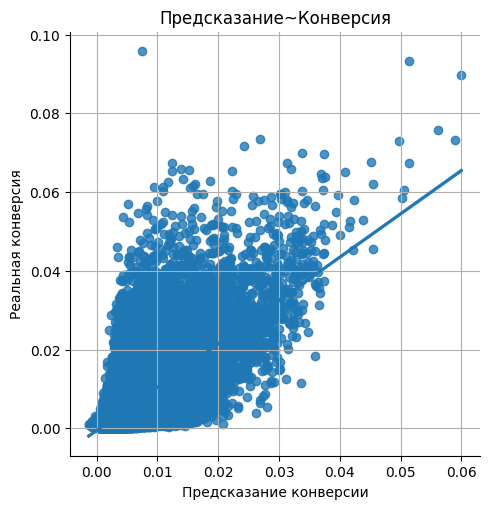

In [70]:
sns.lmplot(data = X_train,x="pred_cat", y='real')
plt.grid()
plt.title("Предсказание~Конверсия")
plt.xlabel("Предсказание конверсии")
plt.ylabel("Реальная конверсия")
plt.show()

<AxesSubplot:xlabel='pred_cat', ylabel='label'>

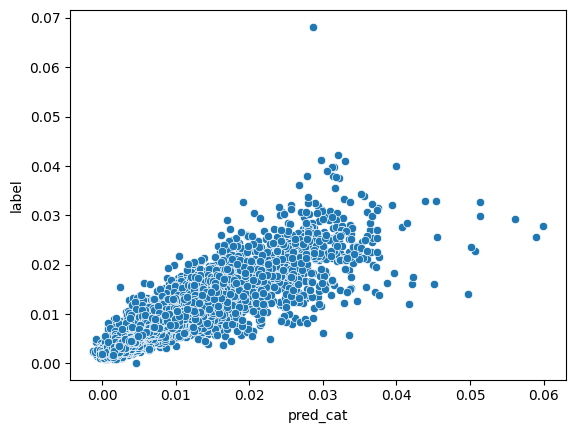

In [65]:
sns.scatterplot(data = X_train, x = 'pred_cat', y = 'label')

In [56]:
# %pip install shap
import shap


[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


     ------------------------------------ 455.5/455.5 kB 919.9 kB/s eta 0:00:00
     ---------------------------------------- 2.7/2.7 MB 1.9 MB/s eta 0:00:00
     --------------------------------------- 28.1/28.1 MB 12.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [57]:
exp = shap.Explainer(model, X_train)
shap_v = exp(X_train)

100%|===================| 110164/110177 [82:42<00:00]        

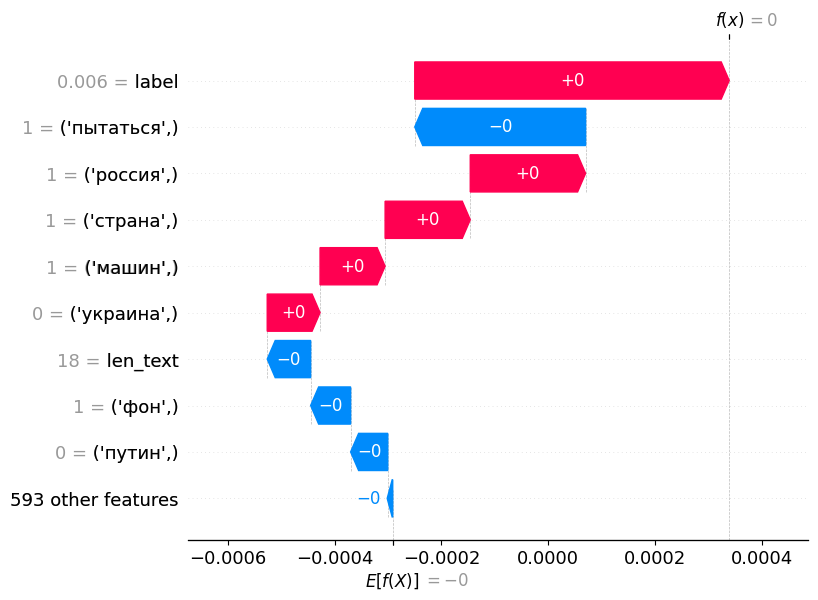

In [61]:
shap.plots.waterfall(shap_v[3])

In [53]:
df_imp = pd.DataFrame(columns = ['col', 'imp'])
df_imp['col'] = X_train.columns
df_imp['imp'] = model.feature_importances_

In [54]:
df_imp.sort_values('imp').tail(20)

,col,imp
8,"('рф',)",0.403381
195,"('санкция',)",0.411631
76,"('сво',)",0.443841
183,"('сообщить',)",0.446008
218,"('зона', 'сво')",0.494024
231,"('мария', 'захаров')",0.519009
11,"('всё',)",0.530597
6,"('кадр',)",0.565011
12,"('человек',)",0.567819
4,"('наш',)",0.568827


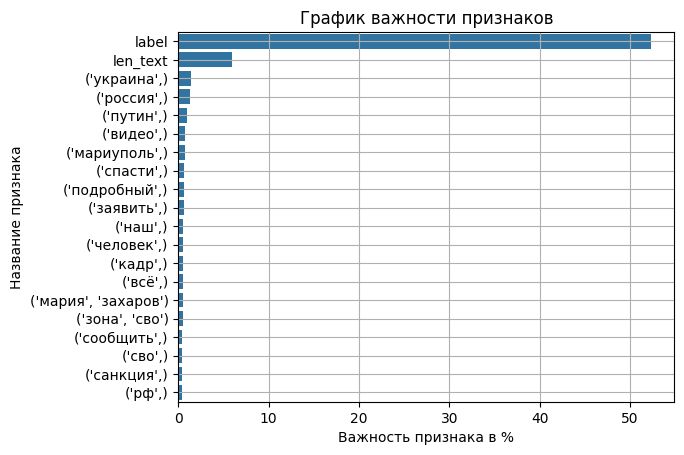

In [55]:
sns.barplot(data = df_imp.sort_values('imp').tail(20).sort_values('imp', ascending = False), y = 'col',x = 'imp')
plt.grid()
plt.title("График важности признаков")
plt.ylabel("Название признака")
plt.xlabel("Важность признака в %")
plt.show()

In [54]:
model

In [56]:
with open("UI_for_model\\analysis_base\\cat_model.pickle", 'wb') as file_one:
        pickle.dump(model, file_one)